In [1]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import string
import json
import numpy as np
import pandas as pd
import re

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
 
ps = PorterStemmer()

In [4]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [5]:
## Only labelled datasets
## dell mee later
file = 'data_sets.json'
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
text = load_doc(directory+file)

loaded_json_all = json.loads(text)

file = 'data_set_citations.json'
directory = '/home/urwa/Documents/Coleridge/ProjectFiles/train_test/train_test/'
citTemp = pd.read_json(directory+file)
labelledDatasets = set(citTemp.data_set_id)

loaded_json=[]
for lj in loaded_json_all:
    if lj['data_set_id'] in labelledDatasets:
        loaded_json.append(lj)

In [6]:
## Abbreviation Disambiguation Module

## load abbreviations
file = 'abbreviations.json'
abbtext = load_doc(file)
abbreviations = json.loads(abbtext)

def findAbbreviation(sentence):
    regex = r"\b[A-Z][A-Z]+\b"
    abbreviations = re.findall(regex, sentence)
    return abbreviations

def expandAbbreviation(sentence, abbdict):
    abbs = findAbbreviation(sentence)
    for a in abbs:
        if a in abbdict:
            sentence = sentence.replace(a,abbdict[a][0])
    return sentence

In [7]:
def specialMapping(word):
    if word == 'studi':
        return 'survey'
    else:
        return word

In [8]:
# turn a doc into clean tokens
def clean_doc(doc):
    # abbreviation disambiguation
    #doc = expandAbbreviation(doc, abbreviations)
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    #tokens = [w for w in tokens if not w in stop_words]
    # stemming
    #tokens = [ps.stem(word) for word in tokens]
    #specialMapping
    #tokens = [specialMapping(word) for word in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [9]:
# load doc and add to vocab
def add_doc_to_vocab(dataset, vocab):
    # load doc
    #doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' '), ' '.join(dataset['mention_list'])])
    #doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' ')
    doc = dataset['title']
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

In [38]:
# save list to file
def save_list(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [46]:
# define vocab
vocab = Counter()
for dataset in loaded_json:    
    add_doc_to_vocab(dataset, vocab)
tokens = [k for k,c in vocab.items()]
save_list(tokens, 'title_dataset_vocab.txt')
len(tokens)

1284

In [47]:
vocab = load_doc('title_dataset_vocab.txt').split()

In [48]:
dataSetIds = [ dataset['data_set_id'] for dataset in loaded_json ]

In [10]:
titles = [ dataset['title'] for dataset in loaded_json ]

In [11]:
titles

['ANES 1988 Time Series Study',
 'Current Population Survey: Annual Demographic File, 1984',
 'Current Population Survey: Annual Demographic File, 1985',
 'Current Population Survey: Annual Demographic File, 1987',
 'Current Population Survey: Annual Demographic File, 1988',
 'Current Population Survey: Annual Demographic File, 1989',
 'Current Population Survey: Annual Demographic File, 1990',
 'Current Population Survey: Annual Demographic File, 1991',
 'Current Population Survey: Annual Demographic File, 1992',
 'Current Population Survey: Annual Demographic File, 1993',
 'Current Population Survey: Annual Demographic File, 1994',
 'Current Population Survey: Annual Demographic File, 1996',
 'Current Population Survey: Annual Demographic File, 1997',
 'Current Population Survey: Annual Demographic File, 1986',
 'Current Population Survey: Annual Demographic File, 1995',
 'Monitoring the Future: A Continuing Study of the Lifestyles and Values of Youth, 1980',
 'Monitoring the Future:

In [50]:
# load doc, clean and return line of tokens
def data_to_line(dataset, vocab):
	# load the doc
	#doc = " ".join([dataset['description'], dataset['subjects'].replace(',',' '), ' '.join(dataset['mention_list'])])
	doc = dataset['title']
    # clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)

In [51]:
dataLines = []
for data in loaded_json:
    dataLines.append(data_to_line(data, vocab))
save_list(dataLines, 'title_datasets_lines.txt')

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# each field as a sentence
docs = load_doc('title_datasets_lines.txt').split('\n')[:100]

# create the tokenizer
vectorizer = TfidfVectorizer(ngram_range=(2, 4))

# fit the tokenizer on the documents
tfidVec = vectorizer.fit(docs)

# encode training data set
dataset_bow = tfidVec.transform(docs)
print(dataset_bow.shape)

(100, 361)


In [53]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(dataset_bow)
dist.shape

(100, 100)

In [54]:
titles = titles[:100]

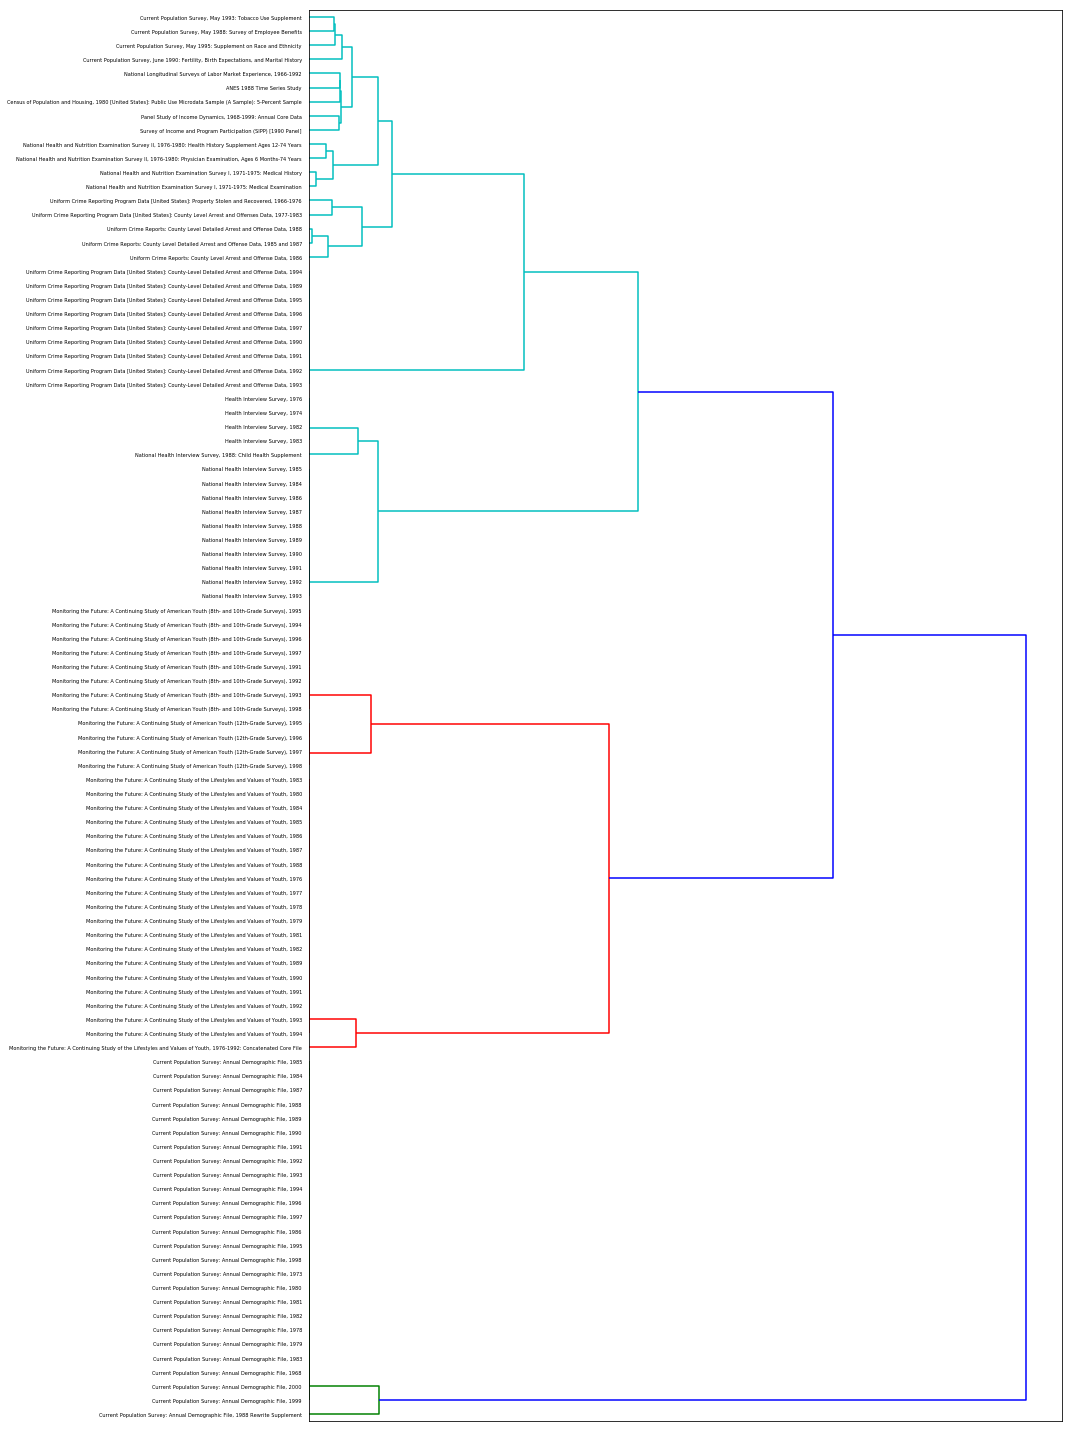

In [55]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [29]:
titleLenghts = [len(t.split()) for t in titles]

In [31]:
min(titleLenghts)

4

In [35]:
[t for t,l in zip(titles,titleLenghts) if l ==4 ]

['Health Interview Survey, 1974',
 'Health Interview Survey, 1976',
 'Health Interview Survey, 1982',
 'Health Interview Survey, 1983']

In [72]:
from sklearn.feature_extraction.text import CountVectorizer


# each field as a sentence
docs = load_doc('title_datasets_lines.txt').split('\n')

# create the tokenizer
vectorizer = CountVectorizer(ngram_range=(3, 100), binary=True)

# fit the tokenizer on the documents
tfidVec = vectorizer.fit(docs)

# encode training data set
dataset_bow = tfidVec.transform(docs)
print(dataset_bow.shape)

(1028, 17463)


In [73]:
ngrams = tfidVec.get_feature_names()
len(ngrams)

17463

In [64]:
def substringSieve(string_list):
    string_list.sort(key=lambda s: len(s), reverse=True)
    out = []
    for s in string_list:
        if not any([s in o for o in out]):
            out.append(s)
    return out

In [74]:
def substringSieve(string_list):
    out = []
    for s in string_list:
        if not any([s in r for r in string_list if s != r]):
            out.append(s)
    return out

In [75]:
Ngrams = substringSieve(ngrams)
len(Ngrams)

516

In [76]:
Ngrams

['abc news clinton terrorism poll august',
 'abc news general election exit poll november',
 'abc news general election exit surveys',
 'abc newsusa todaystanford university pain poll april',
 'abc newswashington post monthly poll april',
 'active for life translation of physical activity programs for midlife and older adults united states',
 'addiction health evaluation and disease ahead management study in boston massachusetts',
 'adolescent substance abuse prevention study asaps detroit houston los angeles newark new orleans st louis',
 'advanced cognitive training for independent and vital elderly active united states',
 'aging status and sense of control asoc united states',
 'alameda county california health and ways of living study and panels',
 'alameda county california health and ways of living study panel',
 'aligning forces for quality evaluation consumer survey round and',
 'american community survey acs public use microdata sample pums',
 'american housing survey metropol

In [77]:
titles

['ANES 1988 Time Series Study',
 'Current Population Survey: Annual Demographic File, 1984',
 'Current Population Survey: Annual Demographic File, 1985',
 'Current Population Survey: Annual Demographic File, 1987',
 'Current Population Survey: Annual Demographic File, 1988',
 'Current Population Survey: Annual Demographic File, 1989',
 'Current Population Survey: Annual Demographic File, 1990',
 'Current Population Survey: Annual Demographic File, 1991',
 'Current Population Survey: Annual Demographic File, 1992',
 'Current Population Survey: Annual Demographic File, 1993',
 'Current Population Survey: Annual Demographic File, 1994',
 'Current Population Survey: Annual Demographic File, 1996',
 'Current Population Survey: Annual Demographic File, 1997',
 'Current Population Survey: Annual Demographic File, 1986',
 'Current Population Survey: Annual Demographic File, 1995',
 'Monitoring the Future: A Continuing Study of the Lifestyles and Values of Youth, 1980',
 'Monitoring the Future: